<a href="https://colab.research.google.com/github/yasinnerten/graduation-thesis/blob/main/Metro_Istanbul_Usage_Prediciton_3_model_%C3%A7al%C4%B1%C5%9Fm%C4%B1%C5%9F_versiyon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
!pip install sktime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf

print('done')

done


In [ ]:
# Load the data
data = pd.read_csv("/content/hourly_transportation_202409.csv")
data

,transition_date,transition_hour,transport_type_id,road_type,line,transfer_type,number_of_passage,number_of_passenger,product_kind,transaction_type_desc,town,line_name,station_poi_desc_cd
0,2024-09-01,0,2,RAYLI,KIRAZLI-BASAKSEHIR/METROKENT,Normal,3,3,TAM,Tam Kontur,BASAKSEHIR,M3,IKITELLI SANAYI
1,2024-09-01,0,2,RAYLI,TOPKAPI-HABIBLER,Normal,1,1,UCRETSIZ,Ucretsiz,SULTANGAZI,T4,HACI SUKRU
2,2024-09-01,0,2,RAYLI,HALKALI - GEBZE,Normal,1,1,TAM,Tam Kontur,FATIH,MARMARAY,YENIKAPI-1
3,2024-09-01,0,3,DENİZ,ADALAR,Normal,1,1,NaN,Tam Kontur,ADALAR,MT-ADA,BUYUKADA
4,2024-09-01,0,2,RAYLI,HALKALI - GEBZE,Normal,1,1,NaN,Tam Kontur,PENDIK,MARMARAY,PENDIK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958384,2024-09-30,0,1,OTOYOL,BEYKOZ-MECIDIYEKOY,Normal,1,1,UCRETSIZ,Ucretsiz,BAKIRKOY,121A,NaN
3958385,2024-09-30,0,1,OTOYOL,BOGAZKOY MH.-BAHCESEHIR-BAKIRKOY,Normal,1,1,INDIRIMLI1,Tam Kontur,BAKIRKOY,146,NaN
3958386,2024-09-30,0,1,OTOYOL,GURPINAR– AVCILAR METROBUS,Normal,1,1,INDIRIMLI2,Indirimli Tip 2 Abonman,BAKIRKOY,458,NaN
3958387,2024-09-30,0,1,OTOYOL,ALEMDAR-HALICIOGLU,Aktarma,1,1,INDIRIMLI1,Tam Aktarma,BAKIRKOY,522,NaN


In [ ]:
filtered_data = data[data['transport_type_id'] == 2].drop(columns=['road_type'], errors='ignore')
data = filtered_data.drop(columns=['transport_type_id'], errors='ignore')
data

,transition_date,transition_hour,line,transfer_type,number_of_passage,number_of_passenger,product_kind,transaction_type_desc,town,line_name,station_poi_desc_cd
0,2024-09-01,0,KIRAZLI-BASAKSEHIR/METROKENT,Normal,3,3,TAM,Tam Kontur,BASAKSEHIR,M3,IKITELLI SANAYI
1,2024-09-01,0,TOPKAPI-HABIBLER,Normal,1,1,UCRETSIZ,Ucretsiz,SULTANGAZI,T4,HACI SUKRU
2,2024-09-01,0,HALKALI - GEBZE,Normal,1,1,TAM,Tam Kontur,FATIH,MARMARAY,YENIKAPI-1
4,2024-09-01,0,HALKALI - GEBZE,Normal,1,1,NaN,Tam Kontur,PENDIK,MARMARAY,PENDIK
8,2024-09-01,0,HALKALI - GEBZE,Normal,1,1,INDIRIMLI1,Indirimli Abonman,TUZLA,MARMARAY,AYDINTEPE
...,...,...,...,...,...,...,...,...,...,...,...
3958324,2024-09-30,0,USKUDAR-CEKMEKOY,Normal,4,4,INDIRIMLI1,Indirimli Abonman,USKUDAR,M5,ALTUNIZADE 1
3958344,2024-09-30,0,YENIKAPI - HACIOSMAN,Normal,4,4,INDIRIMLI1,Indirimli Abonman,SISLI,M2,ITU GUNEY
3958374,2024-09-30,0,KABATAS-MAHMUTBEY,Aktarma,1,1,UCRETSIZ,Tam Aktarma,NaN,M7,ALIBEYKOY DOGU
3958381,2024-09-30,0,YENIKAPI - HACIOSMAN,Normal,2,1,TAM,Tam Kontur,FATIH,M2,HALIC GUNEY


In [ ]:
data

,transition_date,transition_hour,number_of_passenger,station_poi_desc_cd,day_of_week
67,2024-09-01,0,1,DARUSSAFAKA,6
81,2024-09-01,0,5,SISHANE GUNEY,6
83,2024-09-01,0,1,SISHANE KUZEY,6
152,2024-09-01,0,5,HALIC GUNEY,6
160,2024-09-01,0,12,SISHANE KUZEY,6
...,...,...,...,...,...
3958152,2024-09-30,0,1,OSMANBEY 2 GUNEY,0
3958238,2024-09-30,0,1,OSMANBEY 2 GUNEY,0
3958297,2024-09-30,0,1,SEYRANTEPE 2 DOGU,0
3958304,2024-09-30,0,1,GAYRETTEPE,0


In [ ]:
#filtered_data = data[data['line_name'] == "M2"]
#m2_data = filtered_data.drop(columns=['line_name'], errors='ignore')
m2_data = m2_data.drop(columns=['transaction_type_desc','number_of_passage','town','line','transfer_type'], errors='ignore')
m2_data

,transition_date,transition_hour,number_of_passenger,product_kind,station_poi_desc_cd
12,2024-09-01,0,1,INDIRIMLI2,SISLI GUNEY
38,2024-09-01,0,1,INDIRIMLI2,HALIC GUNEY
45,2024-09-01,0,1,INDIRIMLI1,SISLI GUNEY
54,2024-09-01,0,1,INDIRIMLI1,LEVENT 2 KUZEY
67,2024-09-01,0,1,TAM,DARUSSAFAKA
...,...,...,...,...,...
3958238,2024-09-30,0,1,TAM,OSMANBEY 2 GUNEY
3958297,2024-09-30,0,1,TAM,SEYRANTEPE 2 DOGU
3958304,2024-09-30,0,1,TAM,GAYRETTEPE
3958344,2024-09-30,0,4,INDIRIMLI1,ITU GUNEY


In [ ]:
filtered_data = m2_data[m2_data['product_kind'] == "TAM"]
filtered_data = filtered_data.drop(columns=['product_kind'], errors='ignore')
filtered_data.to_csv("m2_tam_bilet_41k.csv", index=False)
data = m2_tam_bilet_41k
data

,transition_date,transition_hour,number_of_passenger,station_poi_desc_cd,hour,day_of_week
67,2024-09-01,0,1,DARUSSAFAKA,0,6
81,2024-09-01,0,5,SISHANE GUNEY,0,6
83,2024-09-01,0,1,SISHANE KUZEY,0,6
152,2024-09-01,0,5,HALIC GUNEY,0,6
160,2024-09-01,0,12,SISHANE KUZEY,0,6
...,...,...,...,...,...,...
3958152,2024-09-30,0,1,OSMANBEY 2 GUNEY,0,0
3958238,2024-09-30,0,1,OSMANBEY 2 GUNEY,0,0
3958297,2024-09-30,0,1,SEYRANTEPE 2 DOGU,0,0
3958304,2024-09-30,0,1,GAYRETTEPE,0,0


In [ ]:
# transition_date sütununu datetime formatına dönüştürme
data['transition_date'] = pd.to_datetime(data['transition_date'])

# Özellik mühendisliği: Tarih ile ilgili özellikler oluşturma
data['day_of_week'] = data['transition_date'].dt.dayofweek  # Haftanın günü özelliğini ekleme

# Özellikleri ve hedef değişkeni tanımlama
categorical_features = ['transition_hour', 'day_of_week']  # transition_hour ve day_of_week kategorik özellikler
X = data[categorical_features]  # Özellikler
y = data['number_of_passenger']  # Hedef değişken

# Ön işleme pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['transition_hour']),  # transition_hour sayısal özelliğini ölçeklendirme
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['day_of_week'])  # Haftanın günü için one-hot encoding
    ]
)

# Ön işlemeyi uygulama
X_processed = preprocessor.fit_transform(X)

# İstasyon bazında veriyi zaman serilerine ayırma
stations = data['station_poi_desc_cd'].unique()
X_stationwise = []
y_stationwise = []

for station in stations:
    station_data = data[data['station_poi_desc_cd'] == station].copy()
    station_features = preprocessor.transform(station_data[categorical_features])

    station_series_X = []
    station_series_y = []

    # 168 saatlik ardışık verileri giriş ve çıkış olarak tanımlama
    for i in range(len(station_features) - 168 * 2):
        station_series_X.append(station_features[i:i + 168])
        station_series_y.append(station_data['number_of_passenger'].values[i + 168:i + 168 * 2])

    X_stationwise.extend(station_series_X)
    y_stationwise.extend(station_series_y)

# Sonuç olarak, numpy dizilerine dönüştürme
import numpy as np
X, y = np.array(X_stationwise), np.array(y_stationwise)

In [ ]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Hyperparameter settings
epochs = 40
batch_size = 64
learning_rate = 0.0001

In [ ]:
from tensorflow.keras.layers import Input, GRU, LSTM, Dropout, Dense

In [ ]:
# Model 1: İlk GRU modeli (tanh varsayılan aktivasyon ile)
input_layer_1 = Input(shape=(X_train.shape[1], X_train.shape[2]))
x1 = GRU(32, return_sequences=True)(input_layer_1)
x1 = Dropout(0.3)(x1)
x1 = GRU(16)(x1)
x1 = Dropout(0.3)(x1)
output_layer_1 = Dense(168, activation='linear')(x1)

model_1 = Model(inputs=input_layer_1, outputs=output_layer_1)
model_1.compile(optimizer=Adam(learning_rate=learning_rate), loss='huber_loss')


In [ ]:
# Model 2: ReLU aktivasyon fonksiyonu ile GRU modeli
input_layer_2 = Input(shape=(X_train.shape[1], X_train.shape[2]))
x2 = GRU(32, activation='relu', return_sequences=True)(input_layer_2)
x2 = Dropout(0.3)(x2)
x2 = GRU(16, activation='relu')(x2)
x2 = Dropout(0.3)(x2)
output_layer_2 = Dense(168, activation='linear')(x2)

model_2 = Model(inputs=input_layer_2, outputs=output_layer_2)
model_2.compile(optimizer=Adam(learning_rate=learning_rate), loss='huber_loss')


In [ ]:
# Model 3: İlk LSTM modeli
input_layer_3 = Input(shape=(X_train.shape[1], X_train.shape[2]))
x3 = LSTM(64, return_sequences=True)(input_layer_3)
x3 = Dropout(0.3)(x3)
x3 = LSTM(32)(x3)
x3 = Dropout(0.3)(x3)
output_layer_3 = Dense(168, activation='linear')(x3)

model_3 = Model(inputs=input_layer_3, outputs=output_layer_3)
model_3.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')


In [ ]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:

# Model 1 eğitimi
history_1 = model_1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/40
317/317 [==============================] - 40s 117ms/step - loss: 27.9780 - val_loss: 27.7296
Epoch 2/40
317/317 [==============================] - 35s 110ms/step - loss: 27.3257 - val_loss: 27.3613
Epoch 3/40
317/317 [==============================] - 36s 114ms/step - loss: 27.0881 - val_loss: 27.2050
Epoch 4/40
317/317 [==============================] - 37s 117ms/step - loss: 26.9779 - val_loss: 27.1305
Epoch 5/40
317/317 [==============================] - 36s 113ms/step - loss: 26.9227 - val_loss: 27.0920
Epoch 6/40
317/317 [==============================] - 36s 112ms/step - loss: 26.8932 - val_loss: 27.0708
Epoch 7/40
317/317 [==============================] - 36s 113ms/step - loss: 26.8766 - val_loss: 27.0589
Epoch 8/40
317/317 [==============================] - 34s 108ms/step - loss: 26.8674 - val_loss: 27.0524
Epoch 9/40
317/317 [==============================] - 36s 113ms/step - loss: 26.8633 - val_loss: 27.0490
Epoch 10/40
317/317 [==============================] - 

In [ ]:

# Model 2 eğitimi
history_2 = model_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/40
317/317 [==============================] - 37s 111ms/step - loss: 27.9366 - val_loss: 27.2960
Epoch 2/40
317/317 [==============================] - 35s 111ms/step - loss: 27.0117 - val_loss: 27.0650
Epoch 3/40
317/317 [==============================] - 36s 114ms/step - loss: 26.9204 - val_loss: 27.0510
Epoch 4/40
317/317 [==============================] - 36s 114ms/step - loss: 26.9005 - val_loss: 27.0491
Epoch 5/40
317/317 [==============================] - 37s 116ms/step - loss: 26.8909 - val_loss: 27.0477
Epoch 6/40
317/317 [==============================] - 36s 112ms/step - loss: 26.8838 - val_loss: 27.0470
Epoch 7/40
317/317 [==============================] - 36s 114ms/step - loss: 26.8795 - val_loss: 27.0468
Epoch 8/40
317/317 [==============================] - 36s 114ms/step - loss: 26.8764 - val_loss: 27.0468
Epoch 9/40
317/317 [==============================] - 35s 109ms/step - loss: 26.8730 - val_loss: 27.0465
Epoch 10/40
317/317 [==============================] - 

In [ ]:

# Model 3 eğitimi
history_3 = model_3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/40
317/317 [==============================] - 50s 149ms/step - loss: 6523.1475 - val_loss: 6606.3848
Epoch 2/40
317/317 [==============================] - 48s 150ms/step - loss: 6443.6855 - val_loss: 6542.4136
Epoch 3/40
317/317 [==============================] - 47s 148ms/step - loss: 6386.7241 - val_loss: 6489.6587
Epoch 4/40
317/317 [==============================] - 46s 146ms/step - loss: 6337.2603 - val_loss: 6441.9927
Epoch 5/40
317/317 [==============================] - 47s 148ms/step - loss: 6292.0771 - val_loss: 6397.8140
Epoch 6/40
317/317 [==============================] - 44s 137ms/step - loss: 6249.7246 - val_loss: 6356.5103
Epoch 7/40
317/317 [==============================] - 48s 150ms/step - loss: 6209.8691 - val_loss: 6317.7642
Epoch 8/40
317/317 [==============================] - 46s 145ms/step - loss: 6173.2324 - val_loss: 6281.3296
Epoch 9/40
317/317 [==============================] - 47s 148ms/step - loss: 6137.4717 - val_loss: 6246.9775
Epoch 10/40
317/317

In [ ]:
# Test sonuçlarını değerlendirme
y_test_pred_1 = model_1.predict(X_test)
y_test_pred_2 = model_2.predict(X_test)
y_test_pred_3 = model_3.predict(X_test)

# RMSE hesaplama
test_rmse_1 = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred_1.flatten()))
test_rmse_2 = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred_2.flatten()))
test_rmse_3 = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred_3.flatten()))

print("Model 1 (GRU, varsayılan aktivasyon) Test Seti RMSE:", test_rmse_1)
print("Model 2 (GRU, ReLU aktivasyon) Test Seti RMSE:", test_rmse_2)
print("Model 3 (LSTM) Test Seti RMSE:", test_rmse_3)

198/198 [==============================] - 7s 34ms/step
Model 1 (GRU, varsayılan aktivasyon) Test Seti RMSE: 80.24378322674146
Model 2 (GRU, ReLU aktivasyon) Test Seti RMSE: 80.24116713412782
Model 3 (LSTM) Test Seti RMSE: 76.01750588403662


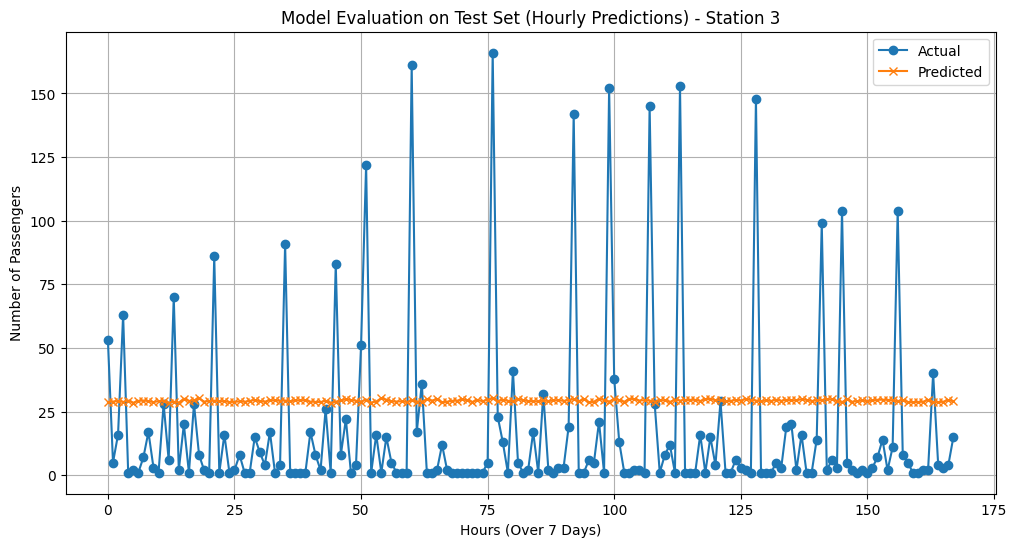

In [ ]:
def plot_results_one_station_seven_days(actual, predicted, title, station_index=2, num_days=1):
    """Plots the actual and predicted values for one station for seven days.

    Args:
        actual: The actual values.
        predicted: The predicted values.
        title: The title of the plot.
        station_index: The index of the station to plot.
        num_days: The number of days to plot.
    """

    plt.figure(figsize=(12, 6))

    # Get data for the specified station and number of days
    actual_station = actual[station_index, :num_days * 168]
    predicted_station = predicted[station_index, :num_days * 168]

    plt.plot(actual_station, label="Actual", marker='o')
    plt.plot(predicted_station, label="Predicted", marker='x')
    plt.title(f"{title} - Station {station_index + 1}")
    plt.xlabel("Hours (Over 7 Days)")
    plt.ylabel("Number of Passengers")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming y_test and y_test_pred are your actual and predicted values
# and they have shape (num_stations, num_hours)
plot_results_one_station_seven_days(y_test, y_test_pred, "Model Evaluation on Test Set (Hourly Predictions)")

In [ ]:
#EOF

In [ ]:
#checkpoint = ModelCheckpoint('/kaggle/working/model_checkpoint.h5.keras', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
#model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint])

In [ ]:
# Load the best model
#model.load_weights('/kaggle/working/model_checkpoint.h5.keras')

In [ ]:
# Make predictions on the test set
#predictions = model.predict(X_test)



```
# @title Varsayılan başlık metni
# Define LSTM model with Bidirectional LSTM layers
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.3)(x)
x = LSTM(32)(x)
x = Dropout(0.3)(x)
output_layer = Dense(168, activation='linear')(x)  # Predicting 168 hourly values

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on test data with RMSE
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred.flatten()))
print("RMSE on Test Set:", test_rmse)
```
Epoch 1/15
634/634 [==============================] - 78s 118ms/step - loss: 6141.9287 - val_loss: 6013.4131
Epoch 2/15
634/634 [==============================] - 72s 114ms/step - loss: 5807.7456 - val_loss: 5875.2275
Epoch 3/15
634/634 [==============================] - 74s 117ms/step - loss: 5748.2134 - val_loss: 5854.4795
Epoch 4/15
634/634 [==============================] - 72s 114ms/step - loss: 5739.8740 - val_loss: 5851.9917
Epoch 5/15
634/634 [==============================] - 73s 116ms/step - loss: 5738.8394 - val_loss: 5851.5781
Epoch 6/15
634/634 [==============================] - 74s 117ms/step - loss: 5739.0259 - val_loss: 5851.5020
Epoch 7/15
634/634 [==============================] - 75s 118ms/step - loss: 5738.7144 - val_loss: 5851.4937
Epoch 8/15
634/634 [==============================] - 74s 116ms/step - loss: 5739.0679 - val_loss: 5851.4424
Epoch 9/15
634/634 [==============================] - 75s 119ms/step - loss: 5738.7021 - val_loss: 5851.4126
Epoch 10/15
634/634 [==============================] - 75s 118ms/step - loss: 5738.5425 - val_loss: 5851.4214
Epoch 11/15
634/634 [==============================] - 73s 115ms/step - loss: 5738.9507 - val_loss: 5851.4126
Epoch 12/15
634/634 [==============================] - 74s 117ms/step - loss: 5738.5063 - val_loss: 5844.7988
Epoch 13/15
634/634 [==============================] - 73s 116ms/step - loss: 5728.2959 - val_loss: 5839.5508
Epoch 14/15
634/634 [==============================] - 75s 119ms/step - loss: 5717.6406 - val_loss: 5831.8447
Epoch 15/15
634/634 [==============================] - 72s 113ms/step - loss: 5709.9351 - val_loss: 5803.7725

[94]
# Evaluate the model on test data with RMSE
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred.flatten()))
print("RMSE on Test Set:", test_rmse)
198/198 [==============================] - 7s 33ms/step
RMSE on Test Set: 75.64395273291461
